In [1]:
import numpy as np
import scipy.linalg as lg
from scipy import signal
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy
import sys
import os
from random import shuffle
sys.path.append('c:\\users\\chang\\miniconda3\\lib\\site-packages')

import librosa
import librosa.display

In [2]:
# Load audio file
rate, data = wav.read("f10.wav")
data = data.flatten(order='F')
data

array([1351, 1351, 1350, ...,  469,  471,  471], dtype=int16)

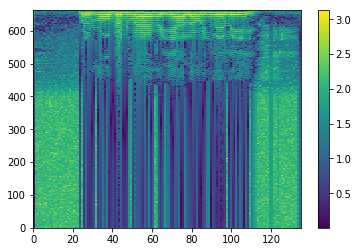

In [3]:
f, t, Sxx = signal.stft(data, rate, window="hamming", nperseg=rate*0.03, noverlap=rate*0.01)
spectrum = np.log(abs(Sxx)+1e-6)

im = plt.imshow(np.sqrt(abs(spectrum)), extent=[0, spectrum.shape[1], 0, spectrum.shape[0]], aspect='auto', interpolation = 'nearest')
plt.colorbar(im)

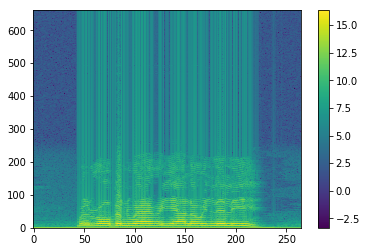

In [4]:
sr,x = wav.read('f10.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

im = plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')
plt.colorbar(im)
plt.show()


In [2]:
data_names = []
data_labels = []
data_mfccs = []

In [3]:
emotionDict = {'happy': 0, 'sad': 1, 'angry': 2, 'fearful': 3}

for dirs in os.listdir('RADVESS/'):
    files = os.listdir('RADVESS/'+ dirs)
    for file in files:
#         print("loading file "+ file + "...")
        f = file.split('-')
        #gender = file[6].split('.')
        inEmotion = False
        if(f[2]=='03'):
            data_labels.append(emotionDict['happy'])
            inEmotion = True
        elif(f[2]=='04'):
            data_labels.append(emotionDict['sad'])
            inEmotion = True
        elif(f[2]=='05'):
            data_labels.append(emotionDict['angry'])
            inEmotion = True
        elif(f[2]=='06'):
            data_labels.append(emotionDict['fearful'])
            inEmotion = True
        if inEmotion == True:
            data_names.append(file)
            # load data
            data, sample_rate = librosa.load('RADVESS/'+dirs+'/'+ file, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5) # data is 110250
            # get mfcc features
            mfccs = librosa.feature.mfcc(y=data.astype(dtype=float), sr=sample_rate, n_mfcc=13) # 13 x 216
            data_mfccs.append(mfccs)

In [4]:
# Convert 2d mfcc features to 1d
features = [np.mean(mfcc, axis=0) for mfcc in data_mfccs] # (216,)
# features = features.astype(dtype='double')
print(len(features), features[0].shape, len(data_names), (data_labels[:10]))

768 (216,) 768 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


In [5]:
# shuffle data
z = list(zip(features, data_labels))
shuffle(z)
features, data_labels = zip(*z)

# split data into train and test set
train_feature = features[0:int(len(features)*0.8)]
test_feature = features[int(len(features)*0.8):]
train_label = data_labels[0:int(len(data_labels)*0.8)]
test_label = data_labels[int(len(data_labels)*0.8):]
print(len(train_feature),len(test_feature),len(train_label),len(test_label))

# Convert list to array
train_feature = np.array(train_feature)
test_feature = np.array(test_feature)
print(train_feature.shape, train_feature[0].shape)
print(len(train_label))

614 154 614 154
(614, 216) (216,)
614


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.utils.data
# import torchvision
# import torchvision.transforms as transforms

from torch.autograd import Variable

In [157]:
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        # Add more conv layers with increasing output channels
        # Add normalization layers after conv layers (nn.BatchNorm2d)
        # Also experiment with kernel size in conv2d layers (say 3
        # inspired from VGGNet)
    
        self.conv_net = nn.Sequential(
            nn.Conv1d(1, 256, kernel_size=5, padding=2), # (216 + 2*2 - 1*(5-1) - 1)/1+1= 216
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(256, 128, kernel_size=5, padding=2), # (216 + 2*2 - 1*(5-1) - 1)/1+1= 216
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.1),
            
            nn.MaxPool1d(kernel_size=8), # 216/8=27
            
            nn.Conv1d(128, 128, kernel_size=5, padding=2), # (27 + 2*2 - 1*(5-1) - 1)/1+1= 27
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(128, 128, kernel_size=5, padding=2), # (27 + 2*2 - 1*(5-1) - 1)/1+1= 27
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            #nn.Flatten(),
        )

        # Add more linear (fc) layers
        # Add normalization layers after linear and
        # experiment inserting them before or after ReLU (nn.BatchNorm1d)
        
        self.fc_net = nn.Sequential(
            nn.Linear(27*128, 8),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(8),
            nn.Linear(8, 4),
            nn.BatchNorm1d(4),
            nn.Softmax(),
        )

    def forward(self, x):
        
        x = self.conv_net(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_net(x)
        return x

# Create an instance of the nn.module class defined above:
net = BaseNet()
net = net.float()

In [158]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum is useful or not
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []

In [159]:
# Train the network
n_batches = 16
EPOCHS = 70
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(int(train_feature.shape[0]/n_batches)+1):
        # Local batches and labels
        if (i+1)*n_batches > train_feature.shape[0]:
            inputs, labels = train_feature[i*n_batches:,:], train_label[i*n_batches:]
        else:
            inputs, labels = train_feature[i*n_batches:(i+1)*n_batches,:], train_label[i*n_batches:(i+1)*n_batches]

        # wrap them in Variable
        inputs = Variable(torch.from_numpy(inputs))
        labels = Variable(torch.from_numpy(np.array(labels)))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs = torch.unsqueeze(inputs,1)
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    # Normalizing the loss by the total number of train batches
    running_loss/=int(train_feature.shape[0]/n_batches)+1
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
#     val_accuracy, val_classwise_accuracy = \
#         calculate_val_accuracy(valloader, IS_GPU)
#     print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    train_loss_over_epochs.append(running_loss)
#     val_accuracy_over_epochs.append(val_accuracy)
# -----------------------------


# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

# plt.subplot(2, 1, 2)
# plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
# plt.ylabel('Val accuracy')
# plt.xlabel('Epochs')
# plt.xticks(np.arange(EPOCHS, dtype=int))
# plt.grid(True)
# plt.savefig("plot.png")
# plt.close(fig)
print('Finished Training')
# -------------

[1] loss: 1.357
[2] loss: 1.316
[3] loss: 1.290
[4] loss: 1.254
[5] loss: 1.225
[6] loss: 1.181
[7] loss: 1.149
[8] loss: 1.116
[9] loss: 1.155
[10] loss: 1.166
[11] loss: 1.092
[12] loss: 1.055
[13] loss: 1.015
[14] loss: 0.987
[15] loss: 0.972
[16] loss: 0.972
[17] loss: 0.950
[18] loss: 0.931
[19] loss: 0.928
[20] loss: 0.927
[21] loss: 0.915
[22] loss: 0.901
[23] loss: 0.877
[24] loss: 0.877
[25] loss: 0.872
[26] loss: 0.854
[27] loss: 0.843
[28] loss: 0.837
[29] loss: 0.843
[30] loss: 0.831
[31] loss: 0.831
[32] loss: 0.821
[33] loss: 0.813
[34] loss: 0.809
[35] loss: 0.808
[36] loss: 0.803
[37] loss: 0.799
[38] loss: 0.797
[39] loss: 0.792
[40] loss: 0.791
[41] loss: 0.789
[42] loss: 0.787
[43] loss: 0.786
[44] loss: 0.785
[45] loss: 0.784
[46] loss: 0.784
[47] loss: 0.783
[48] loss: 0.782
[49] loss: 0.782
[50] loss: 0.781
[51] loss: 0.780
[52] loss: 0.781
[53] loss: 0.780
[54] loss: 0.781
[55] loss: 0.781
[56] loss: 0.780
[57] loss: 0.778
[58] loss: 0.777
[59] loss: 0.777
[60] l

In [160]:
########################################################################
# 5. Try the network on test data, and create .csv file
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
########################################################################

# Check out why .eval() is important!
# https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2
net.eval()

total = 0
predictions = []
# for i in range(test_feature.shape[0]):
data, label = test_feature, test_label
data = Variable(torch.from_numpy(data))

data = torch.unsqueeze(data,1)
print(data.shape)


outputs = net(data.float())
_, predicted = torch.max(outputs.data, 1)
predictions.extend(list(predicted.cpu().numpy()))
#     total += label.size(0)
acc = 0
for l_i, label in enumerate(predictions):
    if label == test_label[l_i]:
        acc += 1
    #print([str(l_i), str(label)], test_label[l_i])
print("accuracy", acc/len(test_label))

torch.Size([154, 1, 216])
accuracy 0.5584415584415584


In [171]:
names = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
test_data = []
for i in range(15):
    d, sr = librosa.load('AudioData/DC/h'+names[i]+'.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2)
    mfcc = np.mean(librosa.feature.mfcc(y=d.astype(dtype=float), sr=sr, n_mfcc=13), axis = 0)
    if(mfcc.shape[0]<216):
        mfcc = np.concatenate((mfcc,mfcc))
        mfcc = mfcc[0:216]
    mfcc = Variable(torch.from_numpy(np.array(mfcc)))
    mfcc = torch.unsqueeze(mfcc, 0)
    mfcc = torch.unsqueeze(mfcc, 0)
    test_data.append(mfcc)

In [172]:
for i in range(15):
    output = net(test_data[i].float())
    print(output.data,np.argmax(output.detach().numpy()))

tensor([[0.0036, 0.0092, 0.9177, 0.0695]]) 2
tensor([[0.0029, 0.0038, 0.9881, 0.0052]]) 2
tensor([[2.7962e-04, 3.0707e-03, 3.8449e-02, 9.5820e-01]]) 3
tensor([[0.0029, 0.0036, 0.9888, 0.0046]]) 2
tensor([[0.0029, 0.0036, 0.9888, 0.0046]]) 2
tensor([[0.0029, 0.0036, 0.9888, 0.0046]]) 2
tensor([[0.0029, 0.0036, 0.9888, 0.0046]]) 2
tensor([[0.0069, 0.0154, 0.7518, 0.2259]]) 2
tensor([[0.0035, 0.0123, 0.7733, 0.2109]]) 2
tensor([[0.0035, 0.0074, 0.9540, 0.0352]]) 2
tensor([[0.0029, 0.0036, 0.9888, 0.0046]]) 2
tensor([[0.0033, 0.0128, 0.6917, 0.2922]]) 2
tensor([[0.0029, 0.0036, 0.9888, 0.0046]]) 2
tensor([[0.0031, 0.0043, 0.9853, 0.0074]]) 2
tensor([[0.0029, 0.0036, 0.9888, 0.0046]]) 2


3